# Animal detection

### Introduction

### Imports and settings

In [97]:
# Standard Python libraries:
import datetime
import operator
import os
import random
import shutil
import sys
from typing import List, Tuple
import warnings

# Data processing and modeling:
from keras.callbacks import TensorBoard
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Data visualization:
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

# Other third-party libraries:
from nptyping import NDArray
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

# Code repository imports:
from googlescraper import GoogleScraper

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
sns.set_theme()

### Data acquisition

In this project we will collect our own data through web scraping. Regarding the web scraper (see the module named 'googlescraper'), credits go to Nikola Zivkovic from [Rubik's Code](https://rubikscode.net/2021/06/21/scraping-images-with-python). All images are automatically converted to type RGB and are saved as jpg files.

In [2]:
# # Set up the appropriate webdriver and define the image scraper:
# headless_options = Options()
# headless_options.add_argument("--headless")  # Makes sure that no browser window is opened.
# driver = webdriver.Chrome(ChromeDriverManager().install(), options=headless_options)
# driver.get("https://google.com")
# scraper = GoogleScraper(driver)

# # Acquire the maximum number of images possible with Google. 
# # Both the animals' English and Latin names are used in the search queries.
# animals = {
#     "buffalo": ["african buffalo", "syncerus caffer"],
#     "elephant": ["african elephant", "loxodonta"], 
#     "leopard": ["african leopard", "panthera pardus pardus"], 
#     "lion": ["lion", "panthera leo"], 
#     "rhinoceros": ["black rhinoceros", "diceros bicornis"],
# }
# data_dir = "data"
# for animal, queries in animals.items():
#     folder = data_dir + animal
#     for query in queries:
#         scraper.scrape_images(query, folder)
#     number_images = len(os.listdir(folder))
#     print(f"Succesfully downloaded {number_images} {animal} images.\n")



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [/Users/tvdaal/.wdm/drivers/chromedriver/mac64/91.0.4472.101/chromedriver] found in cache


Searching for african buffalo...
Searching for syncerus caffer...
Succesfully downloaded 1388 buffalo images.

Searching for african elephant...
Searching for loxodonta...
Succesfully downloaded 1446 elephant images.

Searching for african leopard...
Searching for panthera pardus pardus...
Succesfully downloaded 1398 leopard images.

Searching for lion...
Searching for panthera leo...
Succesfully downloaded 1423 lion images.

Searching for black rhinoceros...
Searching for diceros bicornis...
Succesfully downloaded 1405 rhinoceros images.



### Data exploration

To get a feel for the data we are working with, let us inspect a few random images. For convenience, let us define the following function:

In [25]:
def select_random_img(dir_path: str) -> str:
    """Selects a random image from the provided folder.
    
    Args:
        dir_path: Path to the folder from which a random image 
            needs to be selected.
    
    Returns:
        The path to a random image.
    """
    
    image_paths = [os.path.join(dir_path, image_name) for image_name in os.listdir(dir_path)]
    random.seed(10)
    rand_int = random.randrange(len(image_paths))
    example_path = image_paths[rand_int]
    
    return example_path

Three random images from our dataset:

Size:	 (262, 192)


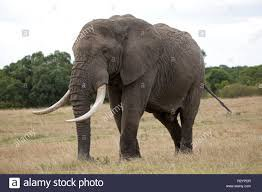

In [85]:
example_path = select_random_img(os.path.join(data_dir, "elephant"))
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Size:	 (2121, 1414)


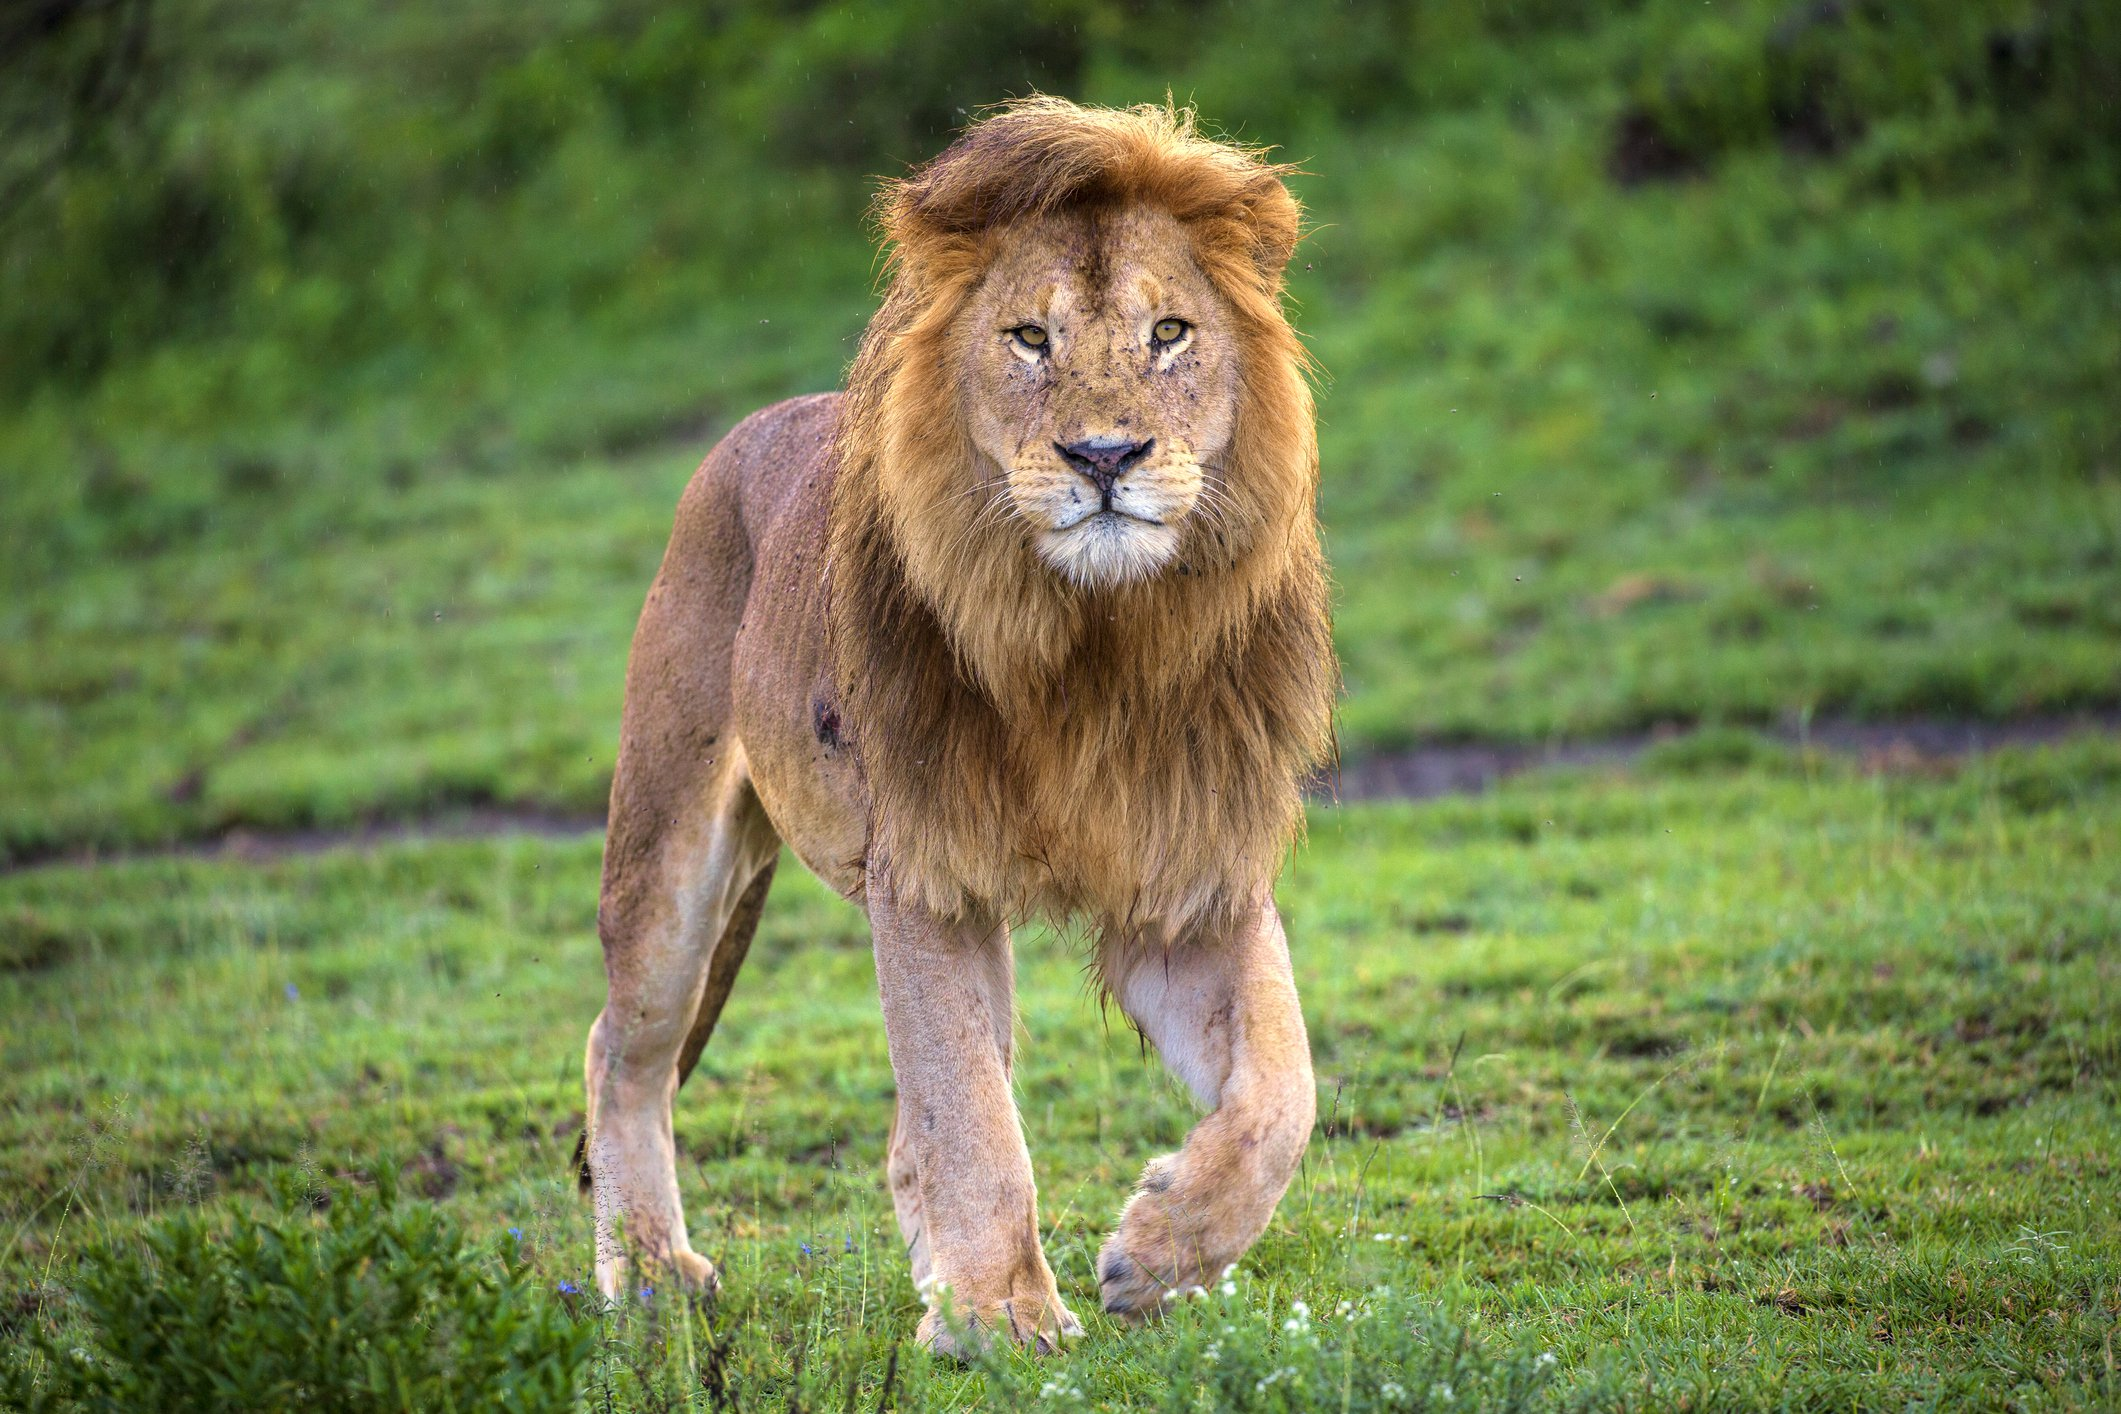

In [27]:
example_path = select_random_img(os.path.join(data_dir, "lion"))
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Size:	 (530, 519)


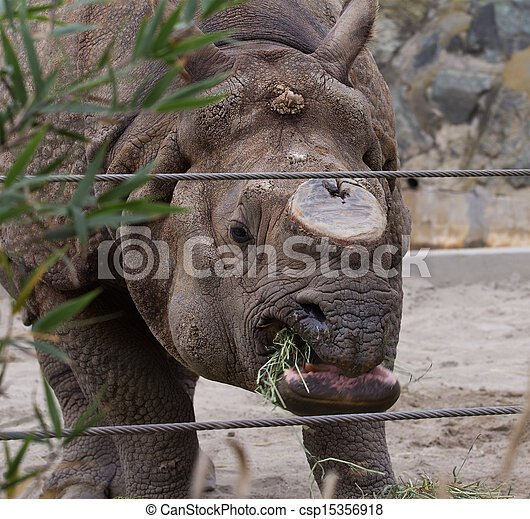

In [28]:
example_path = select_random_img(os.path.join(data_dir, "rhinoceros"))
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Note that the images have different dimensions. As our CNN will require a fixed input size, all images need to have the same resolution. This means that we might need to rescale or drop certain images. In the following we will inspect all resolutions that occur in our dataset. To this end, we will define a function that can obtain the full paths of all images in a given folder:

In [29]:
def get_images(dir_path: str) -> List[str]:
    """Obtain all images in the directory tree of the given folder.

    Args:
        dir_path: The path to the directory.

    Returns:
        List of full paths to all images that are contained in
        the input directory, including subdirectories.
    """

    list_of_items = os.listdir(dir_path)
    all_files = []
    for item in list_of_items:
        full_path = os.path.join(dir_path, item).strip()
        if os.path.isdir(full_path):
            all_files = all_files + get_images(full_path)
        else:
            if full_path.endswith(".jpg"):
                all_files.append(full_path)

    return all_files

An inspection of the full set of images gives the following results:

In [51]:
resolutions = {}
img_paths = get_images(data_dir)
for img_path in img_paths:
    img = load_img(img_path)      
    size = img.size            
    resolution = size[0] * size[1]
    if resolution not in resolutions:
        resolutions[resolution] = 1
    else:
        resolutions[resolution] += 1
resolutions = dict(sorted(resolutions.items(), reverse=True))
size_dataset = len(img_paths)
print(f"There is a total number of {size_dataset} images in the dataset.\n")
print(f"Number of pixels and their count:\n\n{resolutions}")

There is a total number of 7060 images in the dataset.

Number of pixels and their count:

{14870982: 1, 14077952: 1, 13794000: 1, 12493494: 2, 12212224: 4, 12192768: 1, 12052992: 1, 12000000: 1, 11376144: 1, 11297591: 1, 11089920: 1, 10965696: 1, 10960896: 1, 10912062: 1, 10628820: 1, 10480610: 1, 10202112: 1, 10068672: 1, 10036224: 2, 10024000: 1, 9980928: 3, 9830400: 1, 9826326: 1, 9784320: 1, 9777880: 1, 9765504: 1, 9700000: 1, 9690098: 1, 9639261: 1, 9437184: 3, 9407448: 1, 9270294: 1, 8847360: 1, 8800000: 2, 8724485: 1, 8670000: 1, 8329011: 1, 8294400: 1, 8185344: 1, 8165500: 1, 7990272: 1, 7962624: 2, 7750656: 1, 7601856: 1, 7492608: 1, 7307184: 1, 7272782: 1, 7077888: 1, 6899712: 1, 6826500: 1, 6808403: 1, 6756480: 1, 6634958: 1, 6488064: 1, 6476800: 1, 6465701: 1, 6460560: 1, 6291456: 4, 6282240: 1, 6276096: 1, 6252500: 1, 6220800: 1, 6200992: 1, 6200650: 1, 6096000: 1, 6085800: 1, 6072000: 1, 6016000: 2, 6003000: 1, 6000000: 3, 5988000: 1, 5769000: 2, 5762400: 3, 5712500: 1, 

The sizes of the images vary considerably. More specifically, the number of pixels per image ranges from ~10,000 to ~10,000,000; a difference of three orders of magnitude. As we prefer downsampling over upsampling, we need to find a (low) resolution that can serve as the fixed input size for our network such that we still have a sufficient number of images. We will work with a square resolution so that horizontal and vertical images are treated on an equal footing. We can visualize the number of images with a resolution above a given threshold:

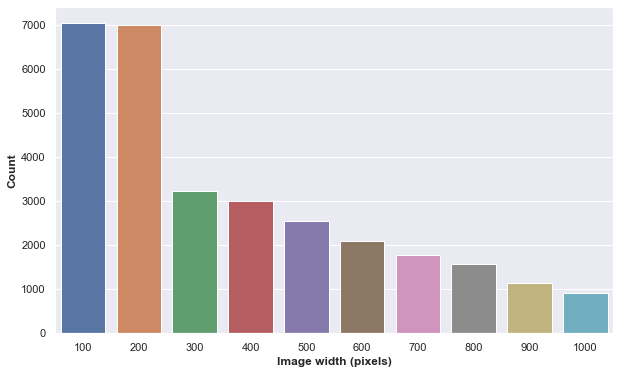

In [82]:
widths = [100 * i for i in range(1, 11)]
sizes = [width ** 2 for width in widths]
total_counts = []
for size in sizes:
    total_count = 0
    for resolution, count in resolutions.items():
        total_count += count if resolution >= size else 0
    total_counts.append(total_count)

plt.figure(figsize=(10,6))
sns.barplot(x=widths, y=total_counts)
plt.xlabel("Image width (pixels)", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.show()

Note the big drop in image count from 200 to 300. If we were to pick 200 as the desired image width, we would retain almost all images. However, as 200 is rather low we prefer a higher resolution. From the chart we infer that the difference between 300 and 400 is neglible and that there is a (small) drop again between 400 and 500. Hence, it seems that 400 would be a reasonable image width to pick where we retain ~3,000 images in total.

### Preprocessing

As customary, we want to create train, dev, and test sets. To this end, we will distribute the original data over these sets in a random fashion, aiming for an 80-10-10 split. We will discard all images that have a resolution less than 400 x 400 = 160,000 pixels. To avoid removing or duplicating data, we will perform this split only virtually; we will simply create separate sets of image paths.

In [93]:
train_set = []
dev_set = []
test_set = []
img_paths = get_images(data_dir)
for img_path in img_paths:
    img = load_img(img_path)      
    size = img.size            
    resolution = size[0] * size[1]
    if resolution >= 400 ** 2:
        rand_int = random.randrange(10)
        if rand_int <= 7:
            train_set.append(img_path)
        elif rand_int == 8:
            dev_set.append(img_path)
        else:
            test_set.append(img_path)

print("Size of training set:\t\t", len(train_set))
print("Size of development set:\t", len(dev_set))
print("Size of test set:\t\t", len(test_set))

Size of training set:		 2357
Size of development set:	 327
Size of test set:		 314


Before we can train a model, we need to put our data into the right form. All images will be downsampled to our target resolution. To compensate for the original non-squareness, we can pad the images with zeros (i.e. add black pixels) to preserve the aspect ratio. For convenience, let us first define a function that resizes and pads images:

In [101]:
def img_resize_pad(
    img_paths: List[str], 
    target_size: Tuple[int, int],
) -> Tuple[NDArray[float], NDArray[float]]:
    """Resize images in given dataset to desired size.
    
    Zero padding is used to respect the original aspect ratio.

    Args:
        img_paths: Collection of (full) image paths.
        target_size: The desired height and width of the images.

    Returns:
        The 4D feature tensor as well as the one-hot-encoded labels.
    """
    
    # Resize images to target dimensions with padding:
    target_height, target_width = target_size
    img_list = []
    label_list = []
    for img_path in img_paths:
        img = load_img(img_path)
        img_arr = img_to_array(img)
        img_pad_arr = tf.image.resize_with_pad(
            img_arr,
            target_height,
            target_width,
        )
        img_pad_arr /= 255.0  # Map pixel values to the inverval [0,1].
        img_list.append(img_pad_arr)
        label = os.path.basename(os.path.dirname(img_path))
        label_list.append(label)

    # Create feature and label tensors:    
    features = np.stack(img_list, axis=0)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(label_list)
    labels = to_categorical(labels)    
    
    return features, labels

Now we are ready to create the input and output tensors for our CNN. Let us start with the training set:

In [102]:
target_size = (400, 400)
train_features, train_labels = img_resize_pad(train_set, target_size)
print("Dimensions of tensor for input features:\t", train_features.shape)
print("Dimensions of tensor for output labels:\t\t", train_labels.shape)

Dimensions of tensor for input features:	 (2357, 400, 400, 3)
Dimensions of tensor for output labels:		 (2357, 5)


Analogously, we can create the dev and test tensors:

In [103]:
dev_features, dev_labels = img_resize_pad(dev_set, target_size)
test_features, test_labels = img_resize_pad(test_set, target_size)

It is good practice to check whether the resized and padded images are indeed what we expect them to be. So let us look at a few examples from the training set:

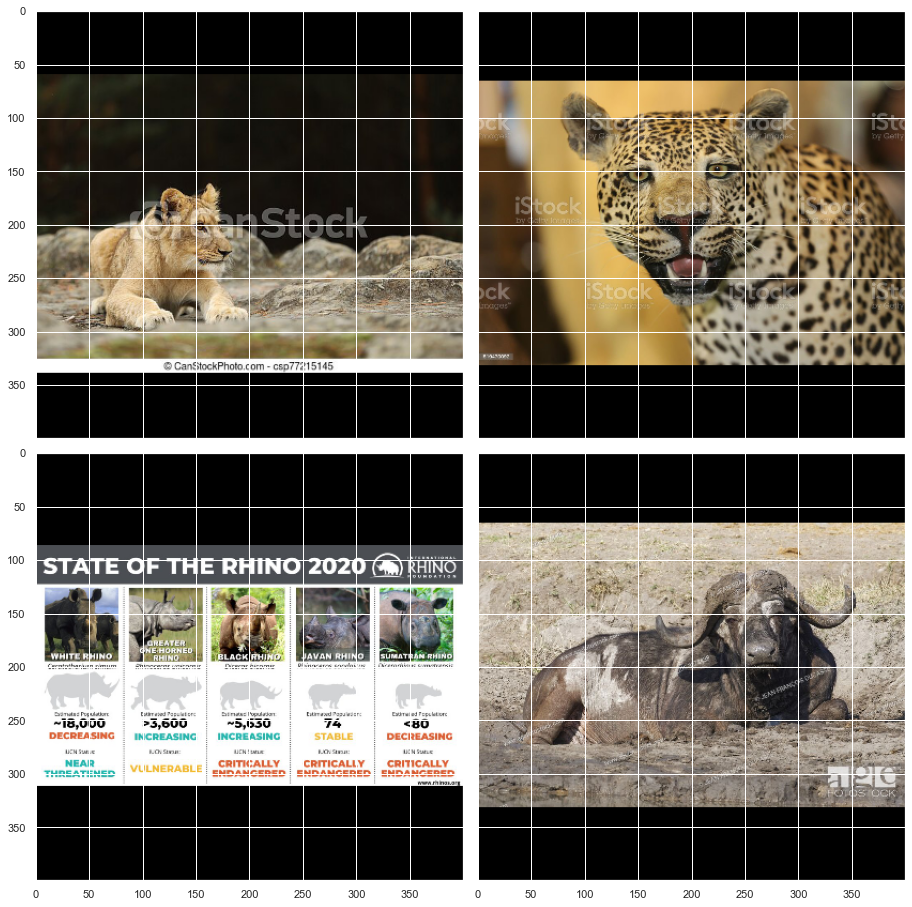

In [104]:
# Randomly select 4 images:
img_arrays = []
for i in range(4):
    random.seed(i)
    rand_int = random.randrange(train_features.shape[0])
    example_array = train_features[rand_int, :, :, :]
    img_arrays.append(example_array)

# Create image grid:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.2)
for ax, im in zip(grid, img_arrays):
    ax.imshow(im)
plt.show()

### Model building

In this section we build and train a CNN using Keras.

The model architecture is given by:

In [ ]:
num_classes = train_labels.shape[1]

model = Sequential(name="CNN_for_animal_classification")
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(512, 512, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
# model.add(Dropout(0.1, seed=0))
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Flatten())
model.add(Dense(100, activation="relu")) #, kernel_regularizer=l2(l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=0))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

Next, we can set the loss function, the optimization algorithm, and the proper metric:

In [ ]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=['accuracy'],
)

The training and validation sets can be defined using the ImageDataGenerator. Since we only want to apply data augmentation to the training set, we need to set the random seeds in both generators equal to each other.

In [ ]:
# Set parameters:
val_frac = 0.2
batch_size = 8

# Specify training set, including data augmentation:
train_datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0,
    horizontal_flip=True,
#     validation_split=val_frac,
)
train_generator = train_datagen.flow(
    train_features,
    y=train_labels,
    batch_size=batch_size,
#     seed=0,
#     subset="training",
)

# Specify validation set:
val_datagen = ImageDataGenerator() # ImageDataGenerator(validation_split=val_frac)
val_generator = val_datagen.flow(
    val_features, # train_features,
    y=val_labels, # y=train_labels,
    batch_size=batch_size,
#     seed=0,
#     subset="validation",
)

During training, we will visualize the loss function using TensorBoard. To view current progress, use the refresh button.

In [ ]:
# Define TensorBoard callback:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if os.path.isdir("logs"):
    shutil.rmtree("logs")
log_dir = os.path.join("logs", current_time)
tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)

Finally we can train our CNN. The model weights are saved to an h5 file.

In [ ]:
# Train model:
epochs = 5
# model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator,
#     callbacks=[tensorboard_callback],
# 
model.fit(
    x=train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tensorboard_callback],
)

# Visualize loss function:
%load_ext tensorboard
%tensorboard --logdir logs

# Save weights:
weights_path = "weights_" + current_time + ".h5"
model.save_weights(weights_path)

#### To do:

- Add pretrained weights.
- Also try existing network.

### Resources:

- https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/
- https://stats.stackexchange.com/questions/241001/deep-learning-use-l2-and-dropout-regularization-simultaneously
- https://towardsdatascience.com/image-scraping-with-python-a96feda8af2d
- https://github.com/WittmannF/image-scraper